In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import log_loss

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

mpl.rc(group='figure', figsize=(10,8))
plt.style.use('seaborn')

## Load the training dataset
* 576 examples

In [3]:
donations = pd.read_csv('https://s3.amazonaws.com/drivendata/data/2/public/9db113a1-cdbe-4b1c-98c2-11590f124dd8.csv', 
                        header=0, 
                        index_col=0,
                        names=['Months_Since_Last', 'Donations', 'Total_Volume', 
                               'Months_Since_First', 'Made_Donation'])
donations.head()

,Months_Since_Last,Donations,Total_Volume,Months_Since_First,Made_Donation
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [4]:
donations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 619 to 74
Data columns (total 5 columns):
Months_Since_Last     576 non-null int64
Donations             576 non-null int64
Total_Volume          576 non-null int64
Months_Since_First    576 non-null int64
Made_Donation         576 non-null int64
dtypes: int64(5)
memory usage: 27.0 KB


In [5]:
donations.describe()

,Months_Since_Last,Donations,Total_Volume,Months_Since_First,Made_Donation
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


## Load the test dataset
* 200 examples

In [6]:
X_test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/2/public/5c9fa979-5a84-45d6-93b9-543d1a0efc41.csv', 
                     header=0, 
                     index_col=0,
                     names=['Months_Since_Last', 'Donations', 'Total_Volume',
                            'Months_Since_First'])
X_test.head()

,Months_Since_Last,Donations,Total_Volume,Months_Since_First
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4
303,11,11,2750,38
83,4,12,3000,34


In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 659 to 154
Data columns (total 4 columns):
Months_Since_Last     200 non-null int64
Donations             200 non-null int64
Total_Volume          200 non-null int64
Months_Since_First    200 non-null int64
dtypes: int64(4)
memory usage: 7.8 KB


## Split the training dataset into feature (X) and label dataframes (y)

In [8]:
X_donations = donations.drop('Made_Donation', axis=1)
X_donations.head()

,Months_Since_Last,Donations,Total_Volume,Months_Since_First
619,2,50,12500,98
664,0,13,3250,28
441,1,16,4000,35
160,2,20,5000,45
358,1,24,6000,77


In [9]:
y_donations = donations['Made_Donation']
y_donations.head()

619    1
664    1
441    1
160    1
358    0
Name: Made_Donation, dtype: int64

## Combine the training and test datasets temporarily to make it easier to analyze

In [10]:
X_combined = pd.concat([X_donations, X_test], axis=0)
print(f'X_combined: {X_combined.shape}')

X_combined: (776, 4)


## Total_Volume is always 250 times the number of donations so it is a redundant feature.
* We will drop this feature.

In [11]:
volume_per_donation = X_combined.Total_Volume / X_combined.Donations
volume_per_donation.value_counts()

250.0    776
dtype: int64

## There are several cases where there appear to have been multiple donations given on the first and only donation. This would appear to be erroneous information which distorts the feature. 
* We will correct these examples and set the number of donations to 1 downstream.

In [12]:
xc = X_donations

multiple_first_donation = (xc['Months_Since_Last'] == xc['Months_Since_First']) & \
                          (xc['Donations'] > 1)
    
xc[multiple_first_donation].sort_values(by='Donations', ascending=False).head()

,Months_Since_Last,Donations,Total_Volume,Months_Since_First
313,14,5,1250,14
335,4,4,1000,4
190,4,4,1000,4
391,2,2,500,2
396,21,2,500,21


## Box plots
* Donations have a lot of outliers

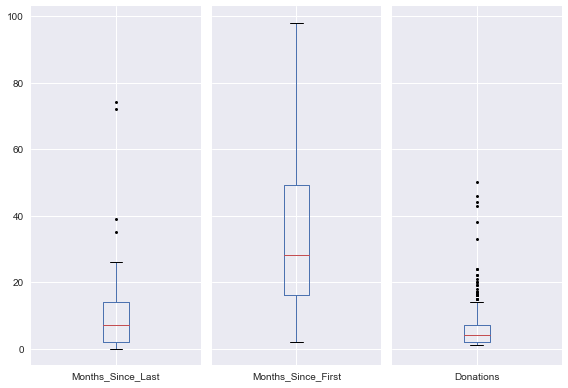

In [13]:
xc = X_donations

fig, axes = plt.subplots(1, 3, sharey=True)
xc['Months_Since_Last'].plot.box(sym='k.', ax=axes[0])
xc['Months_Since_First'].plot.box(sym='k.', ax=axes[1])
xc['Donations'].plot.box(sym='k.', ax=axes[2]);
plt.tight_layout()

## Histograms

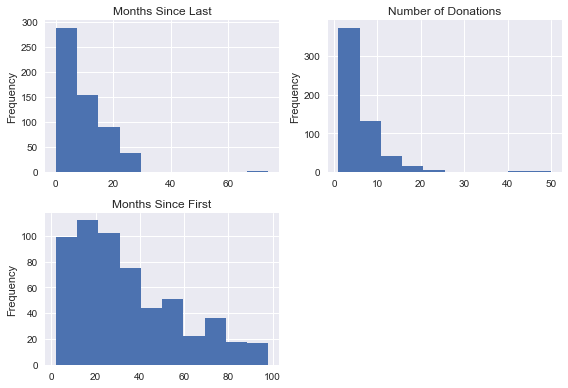

In [14]:
xc = X_donations

fig, axes = plt.subplots(2, 2)
xc['Months_Since_Last'].plot.hist(title='Months Since Last', ax=axes[0,0]);
xc['Donations'].plot.hist(title='Number of Donations', ax=axes[0,1]);
xc['Months_Since_First'].plot.hist(title='Months Since First', ax=axes[1,0]);
axes[1,1].remove()
plt.tight_layout()

## Let's engineer a new feature to reflect the donation rate
* There is a slightly stronger correlation between the donation rate and those who made a donation compared to the number of donations. So we will add this as a new feature.

In [15]:
donations['Current_Donation_Rate'] = donations.Donations / donations.Months_Since_First
donations.corr().Made_Donation

Months_Since_Last       -0.261234
Donations                0.220615
Total_Volume             0.220615
Months_Since_First      -0.019819
Made_Donation            1.000000
Current_Donation_Rate    0.240273
Name: Made_Donation, dtype: float64

## Divide the whole training datset into a smaller training dataset, and a cross validation dataset to be used for out of sample evaluation.
* Use stratify to maintain the same percentage of people who gave donations in the original dataset in the new datasets.

In [16]:
X_train, X_cross, y_train, y_cross = train_test_split(X_donations, 
                                                      y_donations,
                                                      test_size=0.2,
                                                      stratify=y_donations, 
                                                      random_state=67)

## Apply changes to the training dataset and cross validation dataset
* Drop the Total_Volume feature
* Changes Donations to 1 if only one donation was made but Donations > 1
* Add a new Current_Donation_Rate feature

In [17]:
features = ['Months_Since_Last', 'Donations', 'Months_Since_First']
drop_features = ['Total_Volume']
new_features = ['Current_Donation_Rate']

In [18]:
def transform_dataframe(df):
    df = df.copy()

    # Handle distorted number of donations
    # Change donations to 1
    distorted = (df['Months_Since_Last'] == df['Months_Since_First']) & (df['Donations'] > 1)
    df.loc[distorted, 'Donations'] = 1
    
    # Add new feature
    df['Current_Donation_Rate'] = df.Donations / df.Months_Since_First

    # Drop unused features
    df.drop(drop_features, axis=1, inplace=True)    
    
    return df

In [19]:
X_train = transform_dataframe(X_train)
X_cross = transform_dataframe(X_cross)

## Normalize the feature values

In [20]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

In [21]:
X_train[features] = X_train[features].apply(normalize, axis=0)
X_cross[features] = X_cross[features].apply(normalize, axis=0)

## Try various classifier algorithms to see which look most promising
* Dummy (baseline)
* Logistic Regression
* KNN
* SVM
* Gradient Boosting
* Random Forest
* Ada Boost
* Bagging
* MLP (neural network)

### Goal in the competition is to minimize log loss in predicting the probability the donor made a donation.

In [22]:
def train_cross_val_score(clf, X, y, scoring='neg_log_loss'):
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X, y, scoring=scoring)
    print("Scores: {}".format(scores))
    print("Avg Score: {}".format(scores.mean()))

### Dummy classifier

In [23]:
clf = DummyClassifier(strategy='most_frequent')
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-8.29827745 -8.29827745 -8.18023651]
Avg Score: -8.258930468548362


### Logistic Regression

In [24]:
clf = LogisticRegression(random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.4680469  -0.4536066  -0.54334848]
Avg Score: -0.4883339946082632


### KNN

In [25]:
clf = KNeighborsClassifier()
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-2.35165899 -2.15978689 -3.69215785]
Avg Score: -2.7345345747493046


### SVM

In [26]:
clf = SVC(kernel='linear', probability=True, random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.5474674  -0.55132371 -0.55259935]
Avg Score: -0.5504634868780257


In [27]:
clf = SVC(kernel='poly', probability=True, random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.50240181 -0.53273641 -0.58055789]
Avg Score: -0.5385653725672941


In [28]:
clf = SVC(kernel='rbf', probability=True, random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.49095601 -0.47533713 -0.51709466]
Avg Score: -0.49446260199319925


### Gradient Boosting

In [29]:
clf = GradientBoostingClassifier(random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.50415089 -0.50984003 -0.57954877]
Avg Score: -0.5311798991044093


### Random Forest

In [30]:
clf = RandomForestClassifier(random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-1.74422881 -1.99861349 -2.42671157]
Avg Score: -2.0565179582768116


### Ada Boost

In [31]:
clf = AdaBoostClassifier(random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.6699713  -0.67746031 -0.66927594]
Avg Score: -0.6722358509061493


### Bagging

In [32]:
clf = BaggingClassifier(random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-2.18038247 -1.39202249 -2.42666951]
Avg Score: -1.9996914876260992


### MLP

In [33]:
clf = MLPClassifier(max_iter=3000, random_state=67)
y_pred = train_cross_val_score(clf, X_train, y_train)

Scores: [-0.46002951 -0.43480835 -0.52717243]
Avg Score: -0.4740034289061696


## Which features are most important?
* It depends upon which classifier is used

In [34]:
def train_predict_proba_score(clf, X, y):
    clf.fit(X, y)
    y_pred = clf.predict_proba(X)
    print('Score: ', log_loss(y_true=y, y_pred=y_pred[:,1]))
    return y_pred[:,1]

### Logistic Regression

In [35]:
clf = LogisticRegression()
y_pred = train_predict_proba_score(clf, X_train, y_train)

pd.DataFrame({'feature': X_train.columns, 
              'importance': clf.coef_[0]}).sort_values(by='importance', 
                                                                   ascending=False)

Score:  0.476870369203


,feature,importance
1,Donations,0.813443
3,Current_Donation_Rate,0.079761
2,Months_Since_First,-0.512906
0,Months_Since_Last,-0.657709


### Random Forest

In [36]:
clf = RandomForestClassifier()
y_pred = train_predict_proba_score(clf, X_train, y_train)

pd.DataFrame({'feature': X_train.columns, 
              'importance': clf.feature_importances_}).sort_values(by='importance', 
                                                                   ascending=False)

Score:  0.218778600637


,feature,importance
3,Current_Donation_Rate,0.386504
0,Months_Since_Last,0.214951
2,Months_Since_First,0.206902
1,Donations,0.191643


## Use grid search to determine optimal hyper-parameters for most promising classifiers
* Logistic Regression
* SVM
* Gradient Boosting
* MLP (neural network)

In [37]:
def grid_search_cross_val(clf, X, y, param_grid, scoring='neg_log_loss'):
    grid = GridSearchCV(clf, param_grid=param_grid, scoring=scoring)
    grid.fit(X, y)
    print("Best score: {}".format(grid.best_score_))
    print("Best params: {}".format(grid.best_params_))

### Logistic Regression

In [39]:
clf = LogisticRegression(random_state=67)

param_grid = [
    {'penalty': ['l1', 'l2'] , 'C': [0.1, 0.3, 1.0, 3.0]}
]

grid_search_cross_val(clf, X_train, y_train, param_grid)

Best score: -0.487238407205187
Best params: {'C': 0.3, 'penalty': 'l2'}


### SVM

In [40]:
clf = SVC(probability=True, random_state=67)

param_grid = [
    {'C': [0.1, 0.3, 1.0, 3.0], 'kernel': ['linear', 'poly', 'rbf']}
]

grid_search_cross_val(clf, X_train, y_train, param_grid)

Best score: -0.4827223526825489
Best params: {'C': 3.0, 'kernel': 'rbf'}


In [41]:
clf = SVC(probability=True, random_state=67)

param_grid = [
    {'C': [0.1, 0.3, 1.0, 3.0], 'kernel': ['linear', 'poly', 'rbf']}
]

grid_search_cross_val(clf, X_train, y_train, param_grid)

Best score: -0.4827223526825489
Best params: {'C': 3.0, 'kernel': 'rbf'}


### Gradient Boosting

In [42]:
clf = GradientBoostingClassifier(random_state=67)

param_grid = [
    {'learning_rate': [0.1, 0.3, 1.0, 3.0], 'n_estimators': [30, 100, 300], 
     'max_depth': [2, 3, 4, 5, None]}
]

grid_search_cross_val(clf, X_train, y_train, param_grid)

Best score: -0.4782119450977432
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}


### MLP

In [43]:
clf = MLPClassifier(random_state=67)

param_grid = [
    {'hidden_layer_sizes': [(10,), (30,), (100,)], 
     'max_iter': [3000, 10000, 30000],
     'alpha': [0.00003, 0.0001, 0.0003, 0.001]}
]

grid_search_cross_val(clf, X_train, y_train, param_grid)

Best score: -0.4711310101817777
Best params: {'alpha': 3e-05, 'hidden_layer_sizes': (10,), 'max_iter': 3000}


## Use cross validation dataset to determine out of sample performance

In [44]:
def cross_val_out_of_sample(clf, X_train, y_train, X_cross, y_cross):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_cross)
    print(log_loss(y_true=y_cross, y_pred=y_pred[:,1]))
    return y_pred[:,1]

### Logistic Regression

In [45]:
clf = LogisticRegression(C=0.3, penalty='l2', random_state=67)
y_pred = cross_val_out_of_sample(clf, X_train, y_train, X_cross, y_cross)

0.506109239571


### SVM

In [46]:
clf = SVC(C=1.0, kernel='rbf', probability=True, random_state=67)
y_pred = cross_val_out_of_sample(clf, X_train, y_train, X_cross, y_cross)

0.519254933069


### Gradient Boosting

In [47]:
clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=2, n_estimators=30, random_state=67)
y_pred = cross_val_out_of_sample(clf, X_train, y_train, X_cross, y_cross)

0.524905428793


### MLP

In [48]:
clf = MLPClassifier(alpha=0.00003, hidden_layer_sizes=(10,), max_iter=3000, random_state=67)
y_pred = cross_val_out_of_sample(clf, X_train, y_train, X_cross, y_cross)

0.487025945027


## Prepare the test dataset

In [49]:
X_test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/2/public/5c9fa979-5a84-45d6-93b9-543d1a0efc41.csv', 
                     header=0, index_col=0, 
                     names=['Months_Since_Last', 'Donations', 'Total_Volume', 
                            'Months_Since_First'])
X_test.head()

,Months_Since_Last,Donations,Total_Volume,Months_Since_First
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4
303,11,11,2750,38
83,4,12,3000,34


In [50]:
X_test = transform_dataframe(X_test)
X_test[features] = X_test[features].apply(normalize, axis=0)

In [51]:
X_donations = transform_dataframe(X_donations)
X_donations[features] = X_donations[features].apply(normalize, axis=0)

## Retrain selected classifier on entire training dataset

In [58]:
clf = MLPClassifier(alpha=0.00003, hidden_layer_sizes=(30,), max_iter=3000)
clf.fit(X_donations, y_donations)

MLPClassifier(activation='relu', alpha=3e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Predict if donors in the test dataset will donate blood

In [59]:
y_pred = clf.predict_proba(X_test)
predict_df = pd.DataFrame({'Made Donation in March 2007': y_pred[:,1].round(4)}, 
                          index=X_test.index)
predict_df.head()

,Made Donation in March 2007
659,0.5224
276,0.0948
263,0.2107
303,0.3267
83,0.6045


## Prepare submission file
* The MLP classifier should result in a score of about 0.44.

In [60]:
submission_filename = 'donation_submission_001.csv'
predict_df.to_csv(submission_filename, index=True)